In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from torch.utils.data import DataLoader
from generation.data.data_simulation import Nakagami
from generation.data.dataset_pytorch import SignalsDataset
from generation.process.parametrization import GaussianParametrizer
from generation.train.vanila_gan import run_train, generate_new_signal
from scipy import signal
from sklearn.linear_model import Ridge
import tqdm

### Data preparation

In [2]:
# Data params
SAMPLE_SIZE = 100
Q_LOWER = 0.001
Q_UPPER = 0.999
NU_MIN = 0.9
NU_MAX = 1.2
NU_STEP = 0.00005

nakagami = Nakagami(SAMPLE_SIZE, Q_LOWER, Q_UPPER)
nu_values = np.arange(NU_MIN, NU_MAX, NU_STEP)
data = nakagami.get_nakagami_data(nu_values)

### Data processing

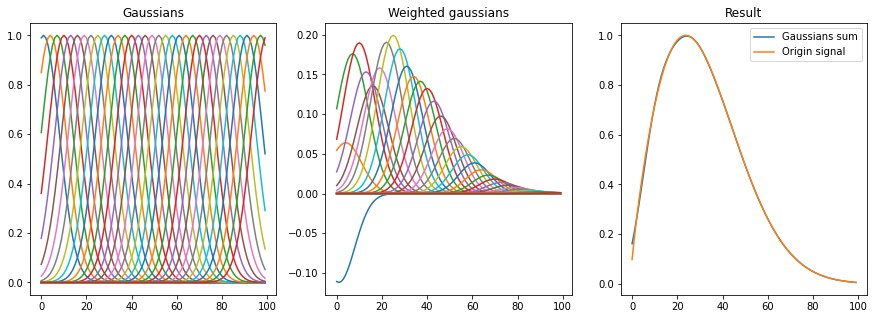

array([-0.1119169 ,  0.06394917,  0.17604464,  0.18971142,  0.1531987 ,
        0.13573964,  0.15823322,  0.19041682,  0.19911999,  0.18243849,
        0.16041263,  0.14754322,  0.14137745,  0.13224965,  0.11628265,
        0.09753831,  0.08144035,  0.06934193,  0.05911257,  0.04880602,
        0.03860987,  0.02985156,  0.02321046,  0.01822805,  0.01410904,
        0.01052192,  0.00760019,  0.00546119,  0.00394631,  0.00279648,
        0.00191127,  0.00134218,  0.00108839,  0.00099851])

In [3]:
### Parametrization params
GAUSSIAN_STD = 7
COMPRESS_COEF = 3
MODEL = Ridge(alpha=0.1, fit_intercept=False)

gaussian_parametrizer = GaussianParametrizer(COMPRESS_COEF, GAUSSIAN_STD, MODEL)
gaussian_parametrizer.transform_signal(data[0], to_visualize=True)

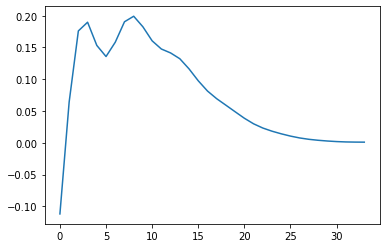

In [4]:
new_data = gaussian_parametrizer.transform_data(data)
plt.plot(new_data[0])
plt.show()

### Training

In [5]:
dataloader = DataLoader(new_data, batch_size=256, shuffle=True)

Iter-0; D_loss: -0.00013753678649663925; G_loss: -0.00973195768892765


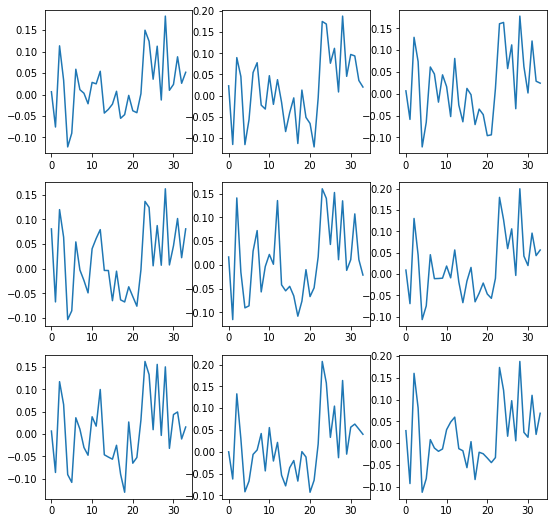

Iter-100; D_loss: -0.00019806716591119766; G_loss: -0.009571293368935585


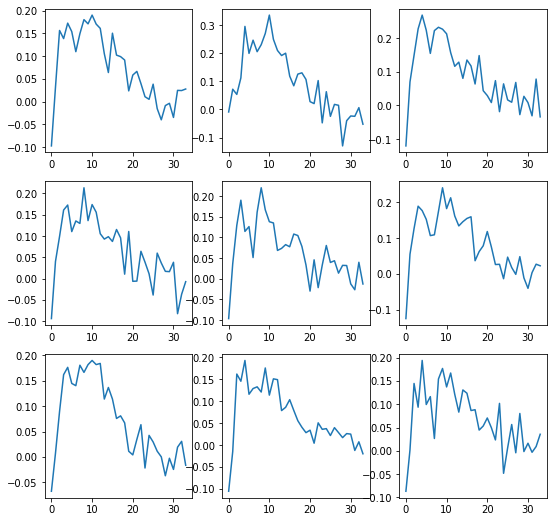

Iter-200; D_loss: -0.00012399442493915558; G_loss: -0.009672511368989944


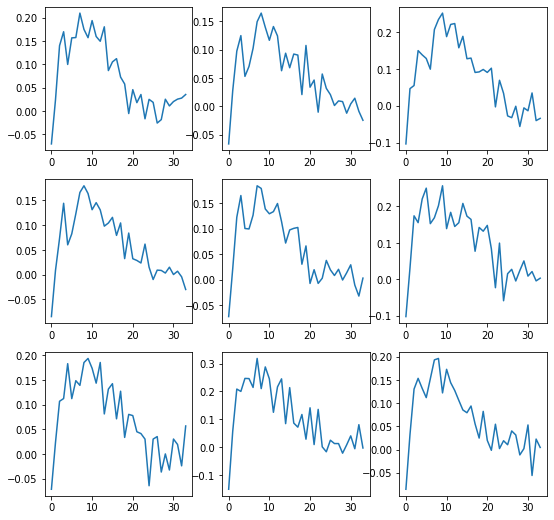

Iter-300; D_loss: -7.795542478561401e-05; G_loss: -0.009701038710772991


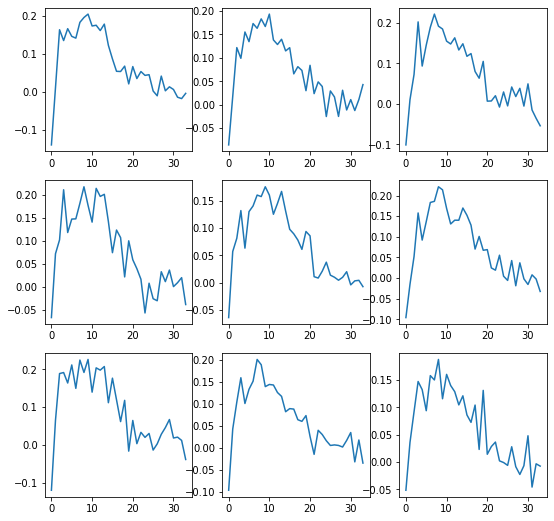

Iter-400; D_loss: -5.859043449163437e-05; G_loss: -0.009768756106495857


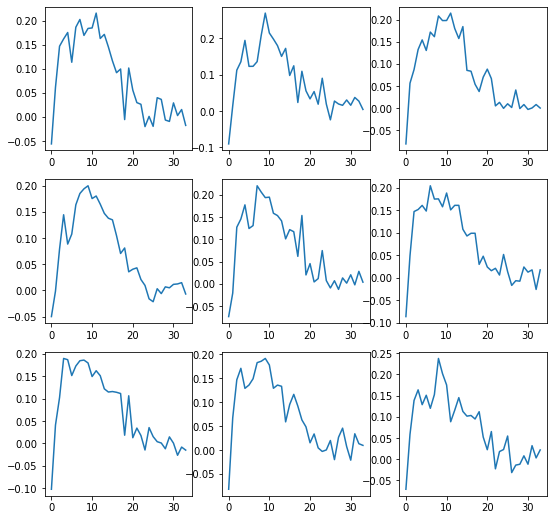

Iter-500; D_loss: -3.8469210267066956e-05; G_loss: -0.009776728227734566


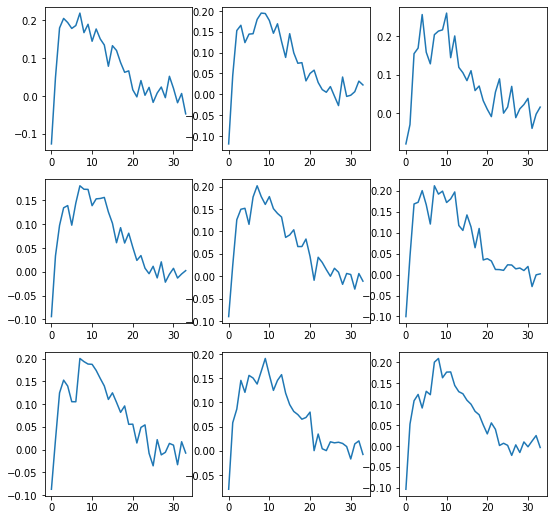

Iter-600; D_loss: -3.4829601645469666e-05; G_loss: -0.009830384515225887


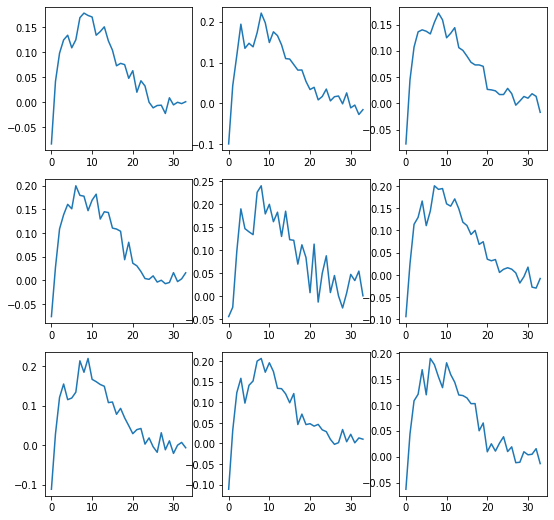

Iter-700; D_loss: -2.353265881538391e-05; G_loss: -0.009769733063876629


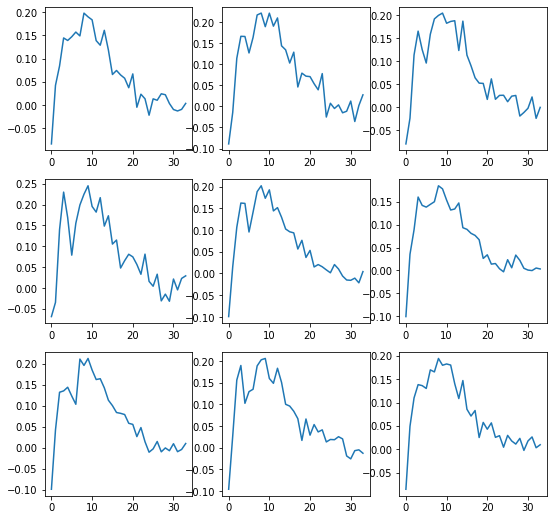

Iter-800; D_loss: -2.3097731173038483e-05; G_loss: -0.009817695245146751


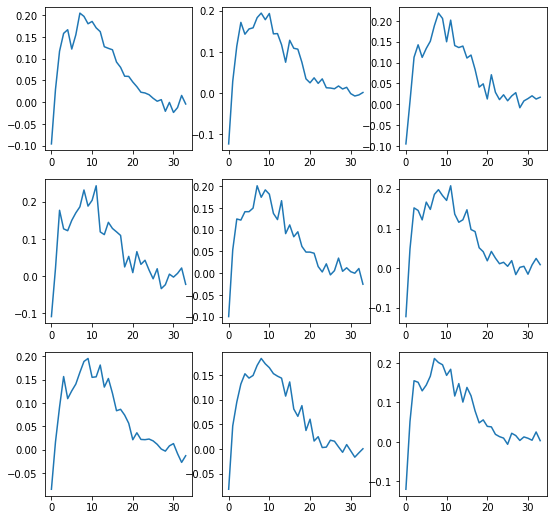

Iter-900; D_loss: -1.4550052583217621e-05; G_loss: -0.009824937209486961


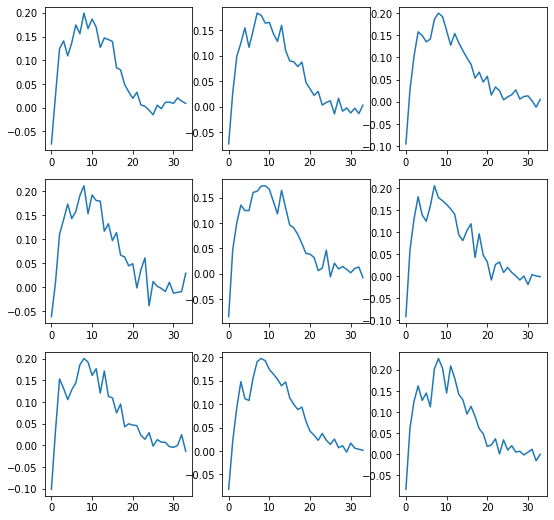

In [6]:
import torch
import torch.nn
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable


mb_size = 128
z_dim = 20
X_dim = len(new_data[0])
h_dim = 32
cnt = 0
lr = 1e-4


G = torch.nn.Sequential(
    torch.nn.Linear(z_dim, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(h_dim, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, X_dim),
    torch.nn.Tanh()
)


D = torch.nn.Sequential(
    torch.nn.Linear(X_dim, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 1),
)


def reset_grad():
    G.zero_grad()
    D.zero_grad()


G_solver = optim.RMSprop(G.parameters(), lr=lr)
D_solver = optim.RMSprop(D.parameters(), lr=lr)


for epoch in range(1000):
    for _ in range(5):
        # Sample data
        z = Variable(torch.randn(mb_size, z_dim))
        X = Variable(next(iter(dataloader))).float()

        # Dicriminator forward-loss-backward-update
        G_sample = G(z)
        D_real = D(X)
        D_fake = D(G_sample)

        D_loss = -(torch.mean(D_real) - torch.mean(D_fake))

        D_loss.backward()
        D_solver.step()

        # Weight clipping
        for p in D.parameters():
            p.data.clamp_(-0.01, 0.01)

        # Housekeeping - reset gradient
        reset_grad()


    # Generator forward-loss-backward-update
    X = Variable(next(iter(dataloader))).float()
    z = Variable(torch.randn(mb_size, z_dim))

    G_sample = G(z)
    D_fake = D(G_sample)

    G_loss = -torch.mean(D_fake)

    G_loss.backward()
    G_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    # Print and plot every now and then
    if epoch % 100 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'
              .format(epoch, D_loss.data.numpy(), G_loss.data.numpy()))

        rows_num = 3
        samples = G(z).data.numpy()[:rows_num**2]
        f, ax = plt.subplots(rows_num, rows_num, figsize=(rows_num**2, rows_num**2))
        for i, sample in enumerate(samples):
            ax[i//rows_num][i % rows_num].plot(sample)
        plt.show()


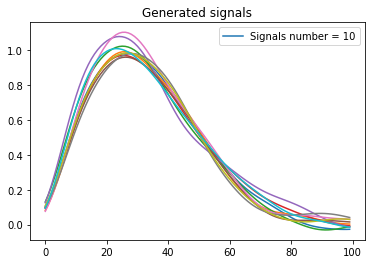

In [18]:
z = Variable(torch.randn(mb_size, z_dim))
samples = G(z).data.numpy()[:10]
plt.title("Generated signals")
for sample in samples:
    result = [0] * SAMPLE_SIZE
    gaussians = gaussian_parametrizer.gaussians
    for j in range(len(gaussians)):
        result += sample[j] * gaussians[j]
    plt.plot(result)
plt.legend(["Signals number = {}".format(len(samples))])
plt.show()

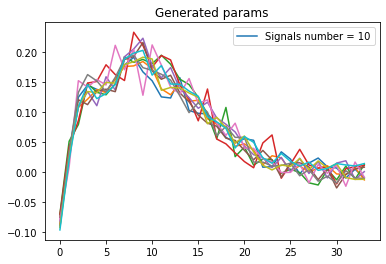

In [17]:
plt.title("Generated params")
for sample in samples:
    plt.plot(sample)
plt.legend(["Signals number = {}".format(len(samples))])
plt.show()